# MNIST but Chinese! Accuracy=99.515%

## Overview

MNIST Data but for Chinese Language is given, the task is to predict the Chinese character from the given image.
The training dataset has around 10000 images and the testing dataset has around 5000 images.

### Acknowledgements
I want to express my gratitude to the following people: Dr. K Nazarpour and Dr. M Chen from Newcastle University, who collected the data.

### Data Description

The Training_data contains images of numbers written in chinese.
train.csv has got a column 'code', it is a coded representation of the chinese numbers, this code is the target variable and the id column carries the name of the image in the Training_Data Folder and the code columns gives the corresponding code.

This is what the Chinese codes stand for, but not at all useful to us.

code==>Chinese number

1) 1 ==> 0
2) 2 ==> 1
3) 3 ==> 2
4) 4 ==> 3
5) 5 ==> 4
6) 6 ==> 5
7) 7 ==> 6
8) 8 ==> 7
9) 9 ==> 8
10) 10 ==> 9
11) 11 ==> 10
12) 12 ==> 100
13) 13 ==> 1000
14) 14 ==> 10000
15) 15 ==> 100000000

### Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, exists, isdir
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets, models
import torchvision.models as models
import torch.optim.lr_scheduler as schedule
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
!ls ../input/mnist-but-chinese/MNIST_Chinese_Hackathon

Testing_Data  Training_Data  sample_submission.csv  test.csv  train.csv


### Loading the csv files

In [2]:
train = pd.read_csv('/kaggle/input/mnist-but-chinese/MNIST_Chinese_Hackathon/train.csv')
test = pd.read_csv('/kaggle/input/mnist-but-chinese/MNIST_Chinese_Hackathon/test.csv')
sample = pd.read_csv('/kaggle/input/mnist-but-chinese/MNIST_Chinese_Hackathon/sample_submission.csv')

#### Spilting Dataset into 80% train and 20% validation

In [3]:
df_tr,df_val = train_test_split(train,random_state=42,test_size=0.2)
print('Training dataset shape ',df_tr.shape)
print('Validation dataset shape ',df_val.shape)

Training dataset shape  (8000, 2)
Validation dataset shape  (2000, 2)


### Ploting the distribution of the Datasets

In [4]:
import seaborn as sns
sns.set_style('whitegrid')

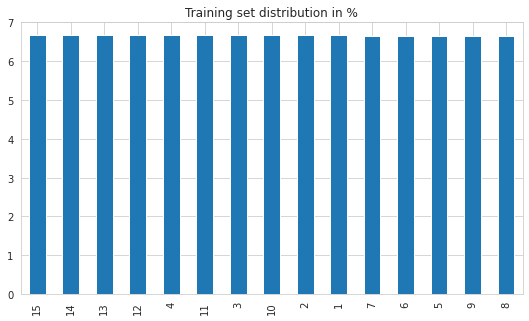

In [5]:
plt.figure(figsize=(9,5))
(train['code'].value_counts()/len(train)*100).plot(kind='bar')
plt.title('Training set distribution in %')
plt.show()

Comparison between Training and Validation set


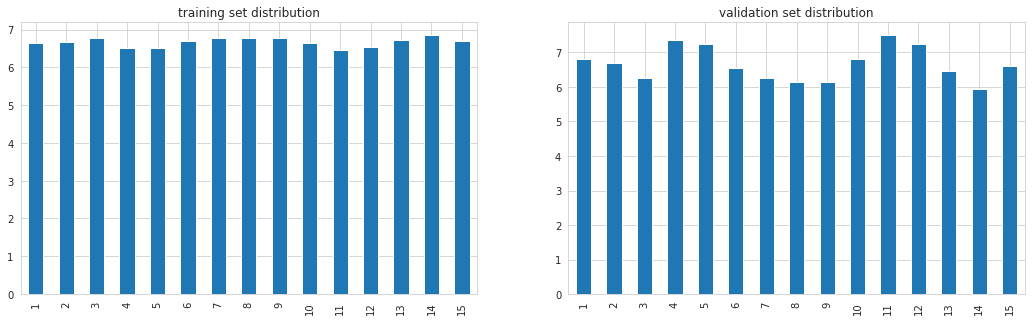

In [6]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
print('Comparison between Training and Validation set')
(df_tr['code'].value_counts()/len(df_tr)*100).sort_index().plot(kind='bar',ax=ax[0],title='training set distribution')
(df_val['code'].value_counts()/len(df_val)*100).sort_index().plot(kind='bar',ax=ax[1],title='validation set distribution')
plt.show()

As there is not much difference between Train and Validation dataset, we will go with it

### Building the Custom Dataset

In [7]:
class builddataset(Dataset):
    def __init__(self,data,root,transforms=None):
        self.data = data 
        self.root = root
        self.transforms = transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        filename = self.root+'/'+str(self.data.iloc[idx,0])
        image = Image.open(filename)
        label = torch.tensor(np.array(self.data.iloc[idx,1]-1))
        if self.transforms:
            image = self.transforms(image)
        return (image,label)

### Data Augmentation

Data Augmentation techniques are used to transform the dataset and create more datapoints to increase the total training examples. This makes the model more robust in classifying unclear images

RandomShift is a technique which helps in shifting the image in both horizontal and vertical directions by the give pixel degree.

In [8]:
from PIL import Image, ImageOps, ImageEnhance
import numbers

class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

#### The transformations for the training dataset that we use here are:-
1. RandomRotation(10): It rotates the image randomly upto a degree of 10

2. RandomShift(6): It shifts the image randomly by a pixel value of upto 6(i.e roughly 10% shift)

3. RandomResizedCrop(64): Randomly crops out a section from the image and resizes it to 64 * 64 pixels.

In [9]:
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       RandomShift(6),
                                       transforms.Resize(64,64),
                                       transforms.RandomResizedCrop(64),
                                       transforms.ToTensor()])

val_transforms = transforms.Compose([transforms.Resize(64,64),
                                     transforms.ToTensor()])

In [10]:
data_dir = '../input/mnist-but-chinese/MNIST_Chinese_Hackathon'

In [11]:
# Training and Validation Datasets
train_ds = builddataset(df_tr,data_dir+'/Training_Data',transforms=train_transforms)
val_ds = builddataset(df_val,data_dir+'/Training_Data',transforms=val_transforms)

# Train and validation Dataloaders
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=32,shuffle=False)

dataloader = {'train':train_dl,'val':val_dl}

### Modelling

In [12]:
import time
import copy

In [13]:
def train_model(model,criterion,optimizer,scheduler,num_epochs):
    since = time.time()
    best_model_p = copy.deepcopy(model.state_dict())
    best_accu = 0.0
    for epoch in range(1,num_epochs+1):
        if epoch%10 == 0:
            print('Epoch: {}/{}'.format(epoch,num_epochs))
        for phase in ['train','val']:
            if(phase=='train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0.0
            for inputs,targets in dataloader[phase]:
                inputs=inputs.cuda()
                targets=targets.cuda()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    targets = torch.flatten(targets)
                    loss = criterion(outputs,targets)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == targets.data).double().item()
            if phase=='train':
                epoch_loss = running_loss/len(train_ds)
                epoch_accu = running_corrects/len(train_ds)
            else:
                epoch_loss = running_loss/len(val_ds)
                epoch_accu = running_corrects/len(val_ds)
                scheduler.step(epoch_loss)
            if epoch%10 == 0:
                print(phase,' Loss: ',epoch_loss,' Accuracy: ',epoch_accu)
            if phase=='val' and epoch_accu >= best_accu:
                best_accu = epoch_accu
                best_model_p = copy.deepcopy(model.state_dict())
    time_taken = time.time()-since
    print("Training Completed in time ",time_taken)
    print("Best Accuracy ",best_accu)
    model.load_state_dict(best_model_p)
    return model

### CNN Model Architecture 1 

In [14]:
import torch.nn as nn
import torch.nn.functional as F

#### Architecture highlights:
1. 4 CNN layers each followed by BatchNorm.
2. 3 MaxPooling layers used to shrink the image channel.
3. 3 Fully connected layears used for final classification

In [15]:
class cnn_model1(nn.Module):
    def __init__(self):
        super(cnn_model1,self).__init__()
        
        self.Conv1 = nn.Conv2d(1,32,3,1,1) 
        self.Bn2d1 = nn.BatchNorm2d(32)
        
        self.Conv2 = nn.Conv2d(32,32,3,1,1) 
        self.Bn2d2 = nn.BatchNorm2d(32)
        self.Max2 = nn.MaxPool2d(2,2)   
        
        self.Conv3 = nn.Conv2d(32,64,3,1,1)
        self.Bn2d3 = nn.BatchNorm2d(64)
        self.Max3 = nn.MaxPool2d(2,2)       
        
        self.Conv4 = nn.Conv2d(64,64,3,1,1) 
        self.Bn2d4 = nn.BatchNorm2d(64)
        self.Max4 = nn.MaxPool2d(2,2)   
        
        
        self.fc1 = nn.Linear(64*8*8,512)
        self.Bn1d1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512,512)
        self.Bn1d2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512,15)
    
    def forward(self,x):
        x = F.relu(self.Bn2d1(self.Conv1(x)))
        x = self.Max2(F.relu(self.Bn2d2(self.Conv2(x))))
        x = self.Max3(F.relu(self.Bn2d3(self.Conv3(x))))
        x = self.Max4(F.relu(self.Bn2d4(self.Conv4(x))))
        x = x.view(x.size(0),-1)
        x = self.drop1(F.relu(self.Bn1d1(self.fc1(x))))
        x = self.drop2(F.relu(self.Bn1d2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [16]:
model1 = cnn_model1()
model1.cuda()
print('model1 in GPU')

model1 in GPU


In [17]:
criterion1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(),lr=0.003)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1,patience=5,factor=0.2,min_lr=0.0000001)

In [18]:
trained_model1 = train_model(model1,criterion1,optimizer1,scheduler1,num_epochs=40)

Epoch: 10/40
train  Loss:  0.6581621673107148  Accuracy:  0.782625
val  Loss:  0.09842261873185634  Accuracy:  0.9705
Epoch: 20/40
train  Loss:  0.5123141230344772  Accuracy:  0.8345
val  Loss:  0.06877755068987608  Accuracy:  0.982
Epoch: 30/40
train  Loss:  0.5142807129621506  Accuracy:  0.832625
val  Loss:  0.15030322915315628  Accuracy:  0.9805
Epoch: 40/40
train  Loss:  0.47835737860202787  Accuracy:  0.841375
val  Loss:  0.024959270052495413  Accuracy:  0.9965
Training Completed in time  596.7969219684601
Best Accuracy  0.9965


### CNN Model Architecture 2

#### Architecture highlights
It follows the general design of the LeNet5 architecture with some changes:
1. MaxPooling layers have been replaced by CNN layers with 2 strides thus forming learnable pooling layers.
2. BatchNorm is used after every CNN layer and dropout layer is added wherever necessary.

In [19]:
class cnn_model2(nn.Module):
    def __init__(self):
        super(cnn_model2,self).__init__()
        
        self.Conv1 = nn.Conv2d(1,32,3,1,1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.Conv2 = nn.Conv2d(32,32,3,1,1) 
        self.bn2 = nn.BatchNorm2d(32)
        self.Conv3 = nn.Conv2d(32,32,4,2,1) 
        self.bn3 = nn.BatchNorm2d(32)
        self.drop3 = nn.Dropout(p=0.4)
        self.Conv4 = nn.Conv2d(32,64,3,1,1) 
        self.bn4 = nn.BatchNorm2d(64)
        self.Conv5 = nn.Conv2d(64,64,3,1,1)
        self.bn5 = nn.BatchNorm2d(64)
        self.Conv6 = nn.Conv2d(64,64,4,2,1)
        self.bn6 = nn.BatchNorm2d(64)
        self.drop6 = nn.Dropout(p=0.4)
        self.Conv7 = nn.Conv2d(64,64,3,1,1)
        self.bn7 = nn.BatchNorm2d(64)
        
        self.drop_fc = nn.Dropout(p=0.4)
        self.fc = nn.Linear(64*16*16,15)
        
    def forward(self,x):
        x=F.relu(self.bn1(self.Conv1(x)))
        x=F.relu(self.bn2(self.Conv2(x)))
        x=self.drop3(F.relu(self.bn3(self.Conv3(x))))
        x=F.relu(self.bn4(self.Conv4(x)))
        x=F.relu(self.bn5(self.Conv5(x)))
        x=self.drop6(F.relu(self.bn6(self.Conv6(x))))
        x=F.relu(self.bn7(self.Conv7(x)))
        x=x.view(x.size(0),-1)
        x=self.drop_fc(x)
        x=self.fc(x)
        return x

In [20]:
model2 = cnn_model2()
model2.cuda()
print('model2 in GPU')

model2 in GPU


In [21]:
criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.003)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2,patience=5,factor=0.2,min_lr=0.0000001)

In [22]:
trained_model2 = train_model(model2,criterion2,optimizer2,scheduler2,num_epochs=40)

Epoch: 10/40
train  Loss:  0.7097711144685745  Accuracy:  0.764375
val  Loss:  0.12673484027385712  Accuracy:  0.9625
Epoch: 20/40
train  Loss:  0.5008553035110235  Accuracy:  0.834
val  Loss:  0.03346890052780509  Accuracy:  0.9935
Epoch: 30/40
train  Loss:  0.43096122875809667  Accuracy:  0.8525
val  Loss:  0.02646636358834803  Accuracy:  0.997
Epoch: 40/40
train  Loss:  0.42053724828362465  Accuracy:  0.854625
val  Loss:  0.030199305395130067  Accuracy:  0.9925
Training Completed in time  608.8464369773865
Best Accuracy  0.997


#### Evaluating both the models using the validation dataset

In [23]:
def evaluate(model):
    model.eval()
    running_loss = 0
    running_corrects = 0
    for inputs,targets in dataloader['val']:
        inputs = inputs.cuda()
        targets = targets.cuda()
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        targets = torch.flatten(targets)
        running_corrects += torch.sum(preds == targets.data)
    print("Accuracy: ",running_corrects.item()/len(val_ds))
    return

In [24]:
print('Accuracy score on the validation set using CNN Model 1: ')
evaluate(trained_model1)

print('Accuracy score on the validation set using CNN Model 2: ')
evaluate(trained_model2)

Accuracy score on the validation set using CNN Model 1: 
Accuracy:  0.9965
Accuracy score on the validation set using CNN Model 2: 
Accuracy:  0.997


### Model Ensembling

Although both the models defined above work just fine, there is still some chance that these models dont generalize well. Hence, it is always useful to ensemble models to cancel the noise in the dataset and make the model as robust as possible.

In [27]:
class ensemble_average(nn.Module):
    def __init__(self,model1,model2):
        super(ensemble_average,self).__init__()
        self.model1 = model1
        self.model2 = model2
    def forward(self,x):
        self.model1.eval()
        for params in self.model1.parameters():
            params.requires_grad = False
        self.model2.eval()
        for params in self.model2.parameters():
            params.requires_grad = False
        out1 = self.model1(x)
        out2 = self.model2(x)
        out = (out1+out2)/2
        return out

Here I didnt do much, just took the average output from the two models defined above. I tried some other techniques as well like using a fully connected layer to account for the outputs from the two models but this average ensemble technique gave a better score on the validation set as well as private leaderboard.

In [28]:
ensembled_model = ensemble_average(trained_model1,trained_model2)

In [29]:
print('Accuracy score on the validation set using ensembled(Average) model: ')
evaluate(ensembled_model)

Accuracy score on the validation set using ensembled(Average) model: 
Accuracy:  0.998


So, clearly average ensembled model gives a better score than both the models.

Creating the final submission

In [30]:
# Building custom dataset for the test data

class buildtestdataset(Dataset):
    def __init__(self,data,root,transforms=None):
        self.data = data
        self.root = root
        self.transforms = transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        filename = self.root+'/'+str(self.data.iloc[idx,0])
        image = Image.open(filename)
        if self.transforms:
            image = self.transforms(image)
        return (image)

In [31]:
def create_submission(model):
    test_ds = buildtestdataset(test,data_dir+'/Testing_Data',transforms=transforms.Compose([transforms.Resize(64,64),transforms.ToTensor()]))
    test_dl = DataLoader(test_ds,batch_size=1,shuffle=False)
    predictions = []
    for inputs in test_dl:
        inputs = inputs.cuda()
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        preds = preds.item()
        predictions.append(preds)
    sub = pd.DataFrame(zip(test.id,predictions),columns=['id','code'])
    sub['code'] = sub['code']+1
    sub.set_index('id',inplace=True)
    return sub

In [32]:
sub = create_submission(ensembled_model)
sub.head()

,code
id,
1,14
2,9
3,3
4,11
5,15


In [34]:
sub.to_csv('final_submission.csv')

### Improvements that can be made:-
1. Trying a different CNN architecture.
2. Tuning the existing model parameters even more to perform better.
3. Trying out other model ensemble techniques for better performance